In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from scipy.stats import norm, uniform, lognorm

In [2]:
dat = pd.read_csv('Data/Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18]

In [3]:
dat_adults

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


In [4]:
x_min, x_max = dat_adults['weight'].min(), dat_adults['weight'].max()

### How to determine a good prior for $\beta$?

In [5]:
n_pre_prior = 100

sample_alpha = norm.rvs(size=n_pre_prior, loc=170, scale=10)
sample_beta  = norm.rvs(size=n_pre_prior, loc=0, scale=10)

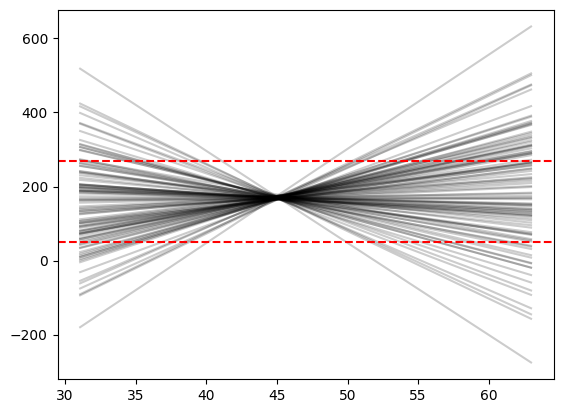

In [6]:
_ = plt.plot([x_min, x_max],
         [sample_alpha+sample_beta*(x_min-dat_adults['weight'].mean()),
          sample_alpha+sample_beta*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)
plt.axhline(50, linestyle='--', color='red')
plt.axhline(270, linestyle='--', color='red')

In [13]:
sample_alpha = norm.rvs(size=n_pre_prior, loc=170, scale=10)
sample_beta  = lognorm.rvs(size=n_pre_prior, s=1) #0.25

(array([60., 25.,  8.,  2.,  1.,  2.,  0.,  1.,  0.,  1.]),
 array([ 0.11483818,  1.52255191,  2.93026564,  4.33797938,  5.74569311,
         7.15340684,  8.56112057,  9.96883431, 11.37654804, 12.78426177,
        14.1919755 ]),
 <BarContainer object of 10 artists>)

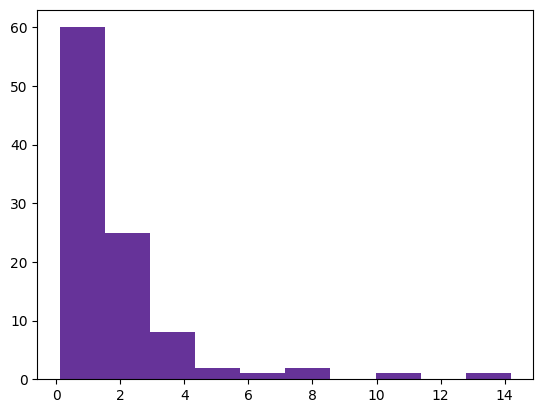

In [14]:
plt.hist(sample_beta, color='rebeccapurple')

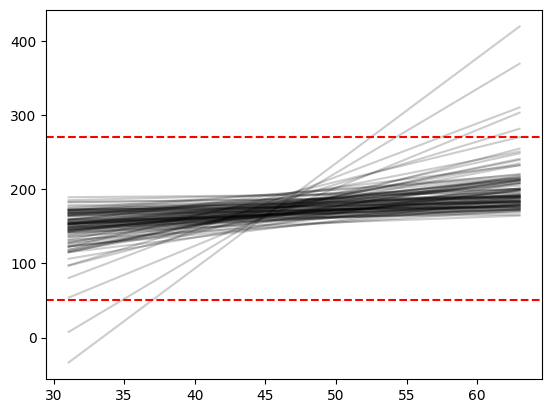

In [15]:
_ = plt.plot([x_min, x_max],
         [sample_alpha+sample_beta*(x_min-dat_adults['weight'].mean()),
          sample_alpha+sample_beta*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)
plt.axhline(50, linestyle='--', color='red')
plt.axhline(270, linestyle='--', color='red')

### Approximating the posterior

In [16]:
alpha_list = np.linspace(153.5, 155.5, 100)
beta_list  = np.linspace(0.5, 1, 100)
sigma_list = np.linspace(4, 6, 100)

alpha_grid, beta_grid, sigma_grid = np.meshgrid(alpha_list, beta_list, sigma_list)

In [17]:
like = []

for i in range(len(alpha_grid.ravel())):
    mu = alpha_grid.ravel()[i] + beta_grid.ravel()[i]*(dat_adults['weight']-dat_adults['weight'].mean())
    like.append(norm.logpdf(dat_adults['height']-mu, 0, sigma_grid.ravel()[i]).sum())
    
like = np.array(like).reshape(alpha_grid.shape)

In [18]:
post_prod = like + norm.logpdf(alpha_grid, 170, 10) + uniform.logpdf(sigma_grid, loc=0, scale=33) + lognorm.logpdf(beta_grid, s=1)

### Sampling from the posterior

In [19]:
n_sample = 10**4

candidates = pd.DataFrame(np.c_[alpha_grid.ravel(), beta_grid.ravel(), sigma_grid.ravel()], columns=['alpha', 'beta', 'sigma'])
sample_ind = random.choices(range(candidates.shape[0]), weights=np.exp(post_prod - post_prod.max()).ravel(), k=n_sample)

sample_posterior = candidates.iloc[sample_ind]

<AxesSubplot:xlabel='alpha', ylabel='beta'>

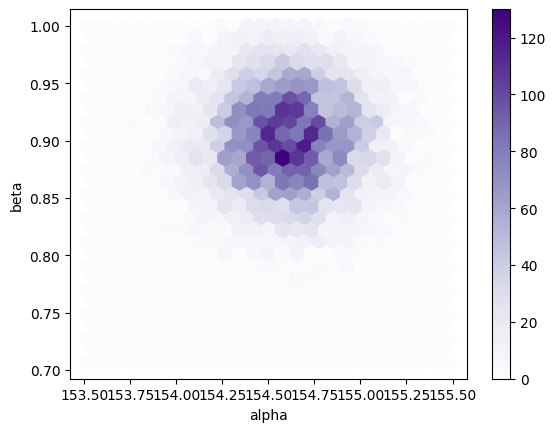

In [20]:
sample_posterior.plot.hexbin(x='alpha', y='beta', cmap='Purples', gridsize=25)

(array([   9.,   45.,  322.,  904., 2158., 2917., 2098., 1163.,  338.,
          46.]),
 array([153.52020202, 153.71616162, 153.91212121, 154.10808081,
        154.3040404 , 154.5       , 154.6959596 , 154.89191919,
        155.08787879, 155.28383838, 155.47979798]),
 <BarContainer object of 10 artists>)

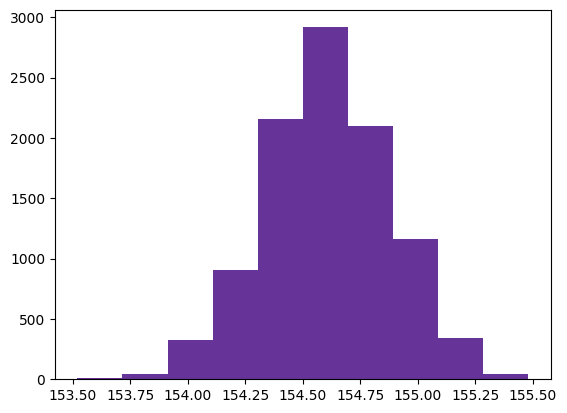

In [21]:
plt.hist(sample_posterior['alpha'], color='rebeccapurple')

(array([2.000e+00, 4.000e+00, 5.200e+01, 2.860e+02, 7.360e+02, 1.958e+03,
        2.730e+03, 2.503e+03, 1.298e+03, 4.310e+02]),
 array([0.70707071, 0.73636364, 0.76565657, 0.79494949, 0.82424242,
        0.85353535, 0.88282828, 0.91212121, 0.94141414, 0.97070707,
        1.        ]),
 <BarContainer object of 10 artists>)

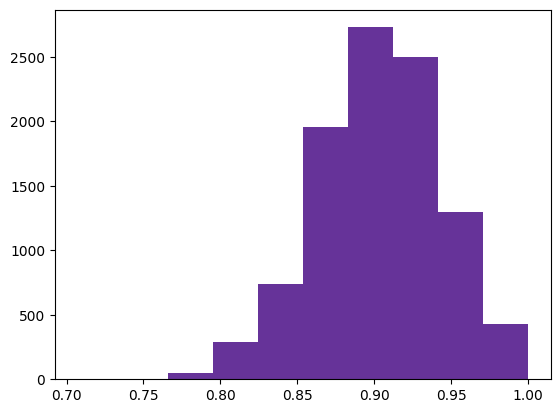

In [22]:
plt.hist(sample_posterior['beta'], color='rebeccapurple')

(array([  24.,  226.,  959., 2619., 2886., 2010.,  968.,  246.,   55.,
           7.]),
 array([4.44444444, 4.59191919, 4.73939394, 4.88686869, 5.03434343,
        5.18181818, 5.32929293, 5.47676768, 5.62424242, 5.77171717,
        5.91919192]),
 <BarContainer object of 10 artists>)

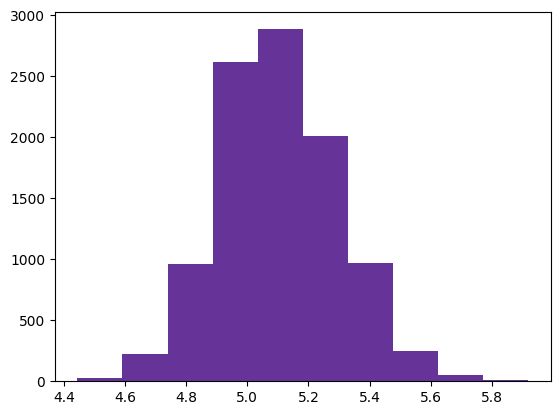

In [23]:
plt.hist(sample_posterior['sigma'], color='rebeccapurple')

In [24]:
sample_posterior.describe()

,alpha,beta,sigma
count,10000.000000,10000.000000,10000.000000
mean,154.607455,0.902312,5.102374
std,0.270780,0.041075,0.193956
min,153.520202,0.707071,4.444444
25%,154.429293,0.873737,4.969697
50%,154.611111,0.904040,5.090909
75%,154.792929,0.929293,5.232323
max,155.479798,1.000000,5.919192


### Model considering the MAPs for $\alpha$ and $\beta$

In [25]:
alpha_map = sample_posterior['alpha'].mode()
beta_map  = sample_posterior['beta'].mode()

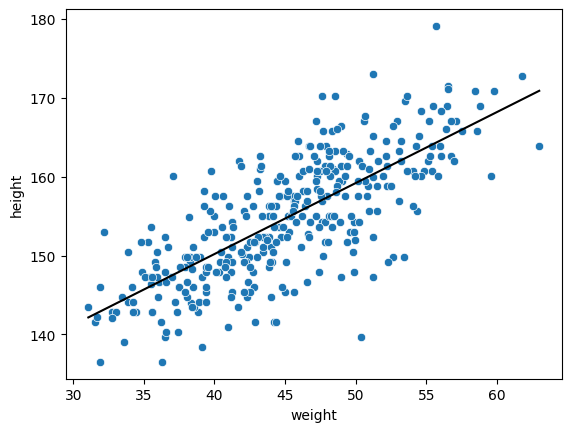

In [26]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k')

### Plotting all the sample of a posteriori models

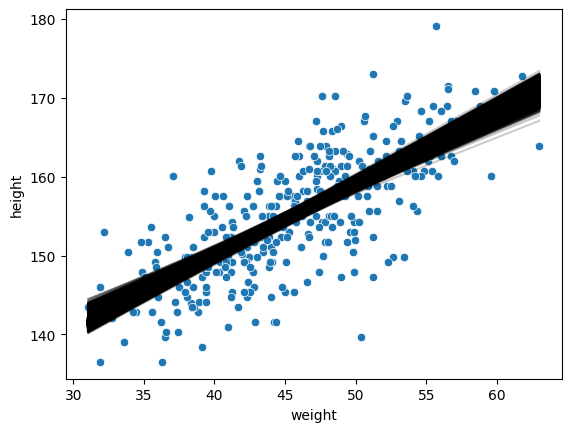

In [27]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
_ = plt.plot([x_min, x_max],
         [sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()),
          sample_posterior['alpha']+sample_posterior['beta']*(x_max-dat_adults['weight'].mean())], color='k', alpha=0.2)

### How much is $\mu$ for a given weight?

/home/dmitri/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

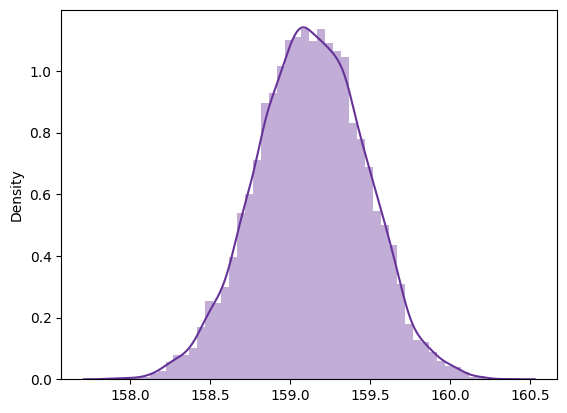

In [28]:
# weight=50
sns.distplot(sample_posterior['alpha']+sample_posterior['beta']*(50-dat_adults['weight'].mean()), color='rebeccapurple')

### Estimating confidence intervals

In [29]:
weight_seq = np.linspace(x_min, x_max)

In [30]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()), [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [31]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(sample_posterior['alpha']+sample_posterior['beta']*(weight_seq[i]-dat_adults['weight'].mean()),
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [32]:
ConfidenceIntervals['weight'] = weight_seq

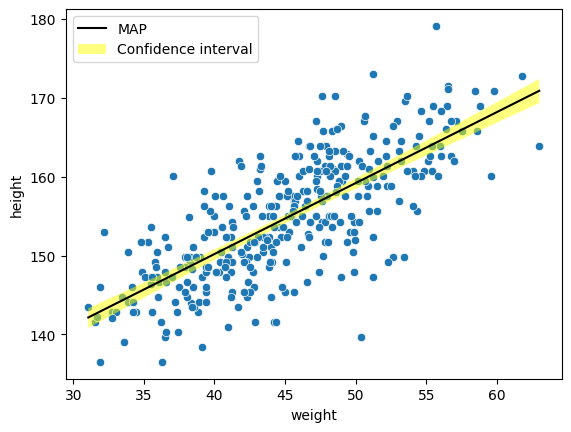

In [33]:
sns.scatterplot(data=dat_adults, x='weight', y='height')
plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k', label='MAP')
plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence interval')
plt.legend()

### Adding prediction intervals

### Predicting height for a given weight

/home/dmitri/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

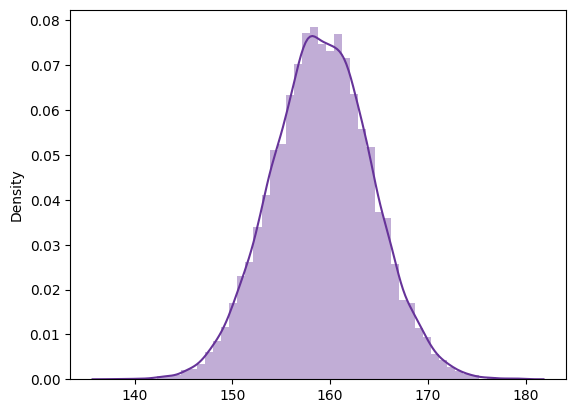

In [34]:
# weight=50
sns.distplot(
    norm.rvs(
        size=n_sample
        , loc=sample_posterior['alpha']+sample_posterior['beta']*(50-dat_adults['weight'].mean())
        , scale=sample_posterior['sigma'])
    , color='rebeccapurple'
)

### Estimating prediction intervals

In [35]:
height_samp = norm.rvs(size=n_sample,
             loc=sample_posterior['alpha']+sample_posterior['beta']*(x_min-dat_adults['weight'].mean()),
             scale=sample_posterior['sigma'])

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [36]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=n_sample,
             loc=sample_posterior['alpha']+sample_posterior['beta']*(weight_seq[i]-dat_adults['weight'].mean()),
             scale=sample_posterior['sigma'])
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [37]:
PredictionIntervals['weight'] = weight_seq

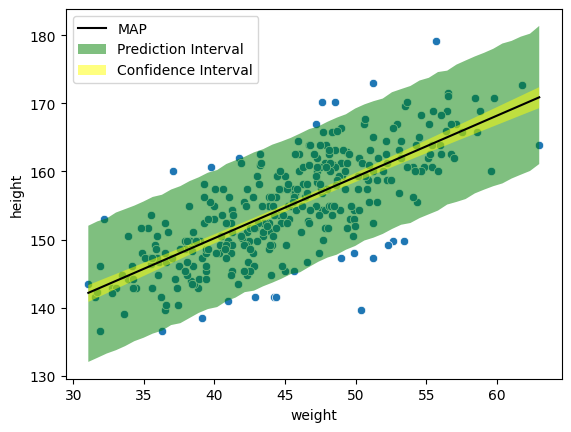

In [31]:
sns.scatterplot(data=dat_adults, x='weight', y='height')

plt.plot([x_min, x_max],
         [alpha_map+beta_map*(x_min-dat_adults['weight'].mean()),
          alpha_map+beta_map*(x_max-dat_adults['weight'].mean())], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()